In [14]:
import  pickle
import numpy as np
import random

In [20]:
with open('dataset_ibm.pkl', 'rb')as f:
    train_dataset, test_dataset = pickle.load(f)

In [41]:
from utils.backend import Backend
# coupling_map = [[4, 3], [3, 4], [2, 3], [3, 2], [1, 2], [2, 1], [0, 1], [1, 0]]
coupling_map = [[3, 4], [2, 3], [1, 2] ,[0, 1]]
topology = {0: [1], 1: [0, 1], 2: [1,3], 3: [2,4], 4: [3]}
backend = Backend(n_qubits=5, topology=topology, neighbor_info=None, coupling_map=coupling_map,
basis_single_gates = ['id', 'rz', 'sx', 'x'], basis_two_gates = ['cx'], divide = False, decoupling = False)

In [22]:
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import random
def plot_scaater(reals, predicts, durations ,name):
    par = np.polyfit(reals, predicts, 1, full=True)
    slope=par[0][0]
    intercept=par[0][1]
    x1 = [0.4, 1.0]
    y1 = [slope*xx + intercept  for xx in x1]
    #定义颜色
    colors = ["#FF3636", '#277C8E' ,"#1F77B4"]
    '''xia <- shang'''
    # colors.reverse()
    # colors = np.array(colors) / 256
    # 定义颜色的位置
    pos = [0, .5, 1]
    # 创建colormap对象
    cmap = LinearSegmentedColormap.from_list('my_colormap', list(zip(pos, colors)))

    normalied_durations = (durations - durations.min())/(durations.max() - durations.min())

    # cmap_name = 'Blues'
    # cmap_name = 'viridis'
    # cmap_name = 'plasma'
    # cmap_name = 'winter'

    random_index = list(range(len(reals)))
    random.shuffle(random_index)
    random_index = random_index[:1500]
    reals = np.array(reals)
    predicts = np.array(predicts)
    fig, axes = plt.subplots(figsize=(10, 10))  # 创建一个图形对象和一个子图对象
    axes.axis([0, 1, 0, 1])
    axes.scatter(reals[random_index], predicts[random_index], c= normalied_durations[random_index], cmap=cmap,alpha = 0.6, s=80 )
    axes.plot(x1,y1)
    axes.set_xlim(.2, 1)
    axes.set_ylim(.2, 1)
    axes.set_xlabel('real ')
    axes.set_ylabel('predict')
    axes.plot([[0,0],[1,1]])
    # fig.colorbar(cm.ScalarMappable( cmap=cmap))
    fig.savefig(name)
    print(slope, intercept)

In [42]:
from upstream import RandomwalkModel
delta_steps = []
for n_steps in range(4):
    upstream_model = RandomwalkModel(n_steps, 20, backend=backend, travel_directions=('parallel', 'former'))
    upstream_model.train(train_dataset+test_dataset, multi_process=True, remove_redundancy=n_steps > 1)

    from downstream import FidelityModel

    downstream_model = FidelityModel(upstream_model)
    downstream_model.train(train_dataset, epoch_num = 300)

    test_predicts, test_reals, durations = [] , [], []
    for circuit_info in test_dataset:

        predict = downstream_model.predict_fidelity(circuit_info)
        circuit_info['predict'] = predict
        durations.append(circuit_info['duration'])
        test_reals.append(circuit_info['ground_truth_fidelity'])
        test_predicts.append(predict)
    
    test_reals = np.array(test_reals)
    test_predicts = np.array(test_predicts)
    durations = np.array(durations)
    plot_scaater(test_reals, test_predicts, durations, name = f'scatter_step{n_steps}.png')
    print('average inaccuracy = ', np.abs(test_predicts - test_reals).mean())
    delta_steps.append(np.abs(np.array(test_reals)-np.array(test_predicts)).tolist())



(remote_train pid=2734218) train:0/259, 0th offest
(remote_train pid=2734218) train:100/259, 0th offest
(remote_train pid=2734218) train:200/259, 0th offest
(remote_train pid=2734248) train:200/259, 777th offest [repeated 9x across cluster]
(remote_train pid=2734248) train:0/259, 1813th offest [repeated 10x across cluster]
count path
random walk finish device size =  9
0 path table size =  2
1 path table size =  2
2 path table size =  2
3 path table size =  2
4 path table size =  2
(3, 4) path table size =  1
(2, 3) path table size =  1
(1, 2) path table size =  1
(0, 1) path table size =  1
n_instruction2circuit_infos =  {180: 16, 506: 6, 436: 5, 186: 9, 480: 5, 588: 4, 116: 13, 174: 8, 378: 8, 142: 28, 484: 2, 444: 10, 236: 15, 344: 17, 350: 6, 316: 7, 270: 4, 518: 3, 384: 8, 222: 15, 290: 14, 442: 7, 450: 8, 158: 14, 382: 10, 164: 19, 504: 5, 358: 8, 192: 11, 366: 10, 340: 9, 226: 12, 482: 7, 346: 9, 544: 9, 400: 8, 274: 7, 294: 12, 580: 5, 534: 6, 420: 11, 360: 9, 262: 16, 218: 15,

KeyboardInterrupt: 

In [27]:
import numpy as np
delta_steps = np.array(delta_steps)
delta_steps.mean(axis=1)

array([0.10253005, 0.09110711, 0.08278848, 0.0812838 ])

In [28]:
pickle.dump(delta_steps,open('delta_steps.pkl','wb'))

In [29]:
from upstream.randomwalk_model import extract_device
def get_baseline_predict(circuit_info, single_average_error, couple_average_error):
    fidelity = 1
    for gate in circuit_info['gates']:
        device = extract_device(gate)
        if isinstance(device,tuple):
            if 'map' in circuit_info:
                device = (circuit_info['map'][device[0]],circuit_info['map'][device[1]])
            fidelity = fidelity * couple_average_error[device]
        else:
            if 'map' in circuit_info:
                device = circuit_info['map'][device]
            fidelity = fidelity * single_average_error[device]
    return fidelity #* np.product((measure0_fidelity + measure1_fidelity) / 2)

In [30]:
rb_single_average_error = {0: 0.9992909, # rb
 1: 0.999802,
 2: 0.9997739,
 3: 0.9998139,
 4: 0.9995106,
}
rb_couple_average_error = {(0,1): 0.99223, # rb
 (1,2): 0.99049,
 (2,3): 0.99424,
 (3,4): 0.99312,
}

0.40743284944774294 0.5497338525609842
0.2597865978257108 0.1259246304011091


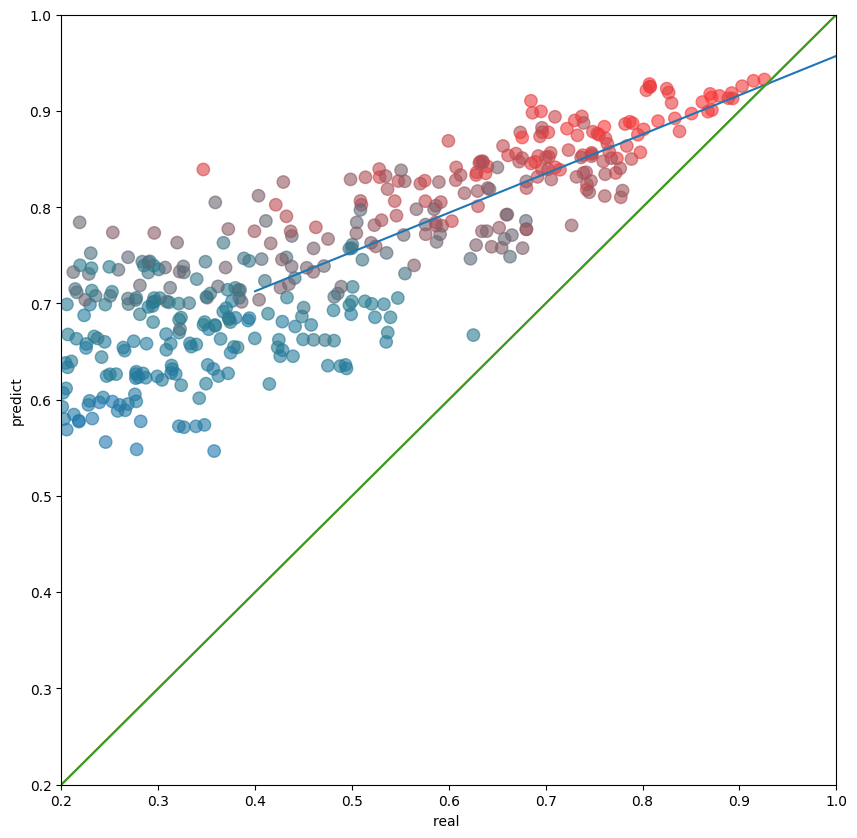

In [31]:
rbs = []
for cir in test_dataset:
    rbs.append(get_baseline_predict(cir, rb_single_average_error, rb_couple_average_error))
rbs = np.array(rbs)
plot_scaater(test_reals, rbs, durations, name = f'scatter_rb.png')
print(np.abs(rbs-test_reals).mean(), np.abs(rbs-test_reals).std())
delta_rb=np.abs(np.array(test_reals)-np.array(rbs)).tolist()


In [32]:
xeb_single_average_error = {0: 0.9994, #xeb
 1: 0.99956,
 2: 0.99918,
 3: 0.99976,
 4: 0.9994,
}
xeb_couple_average_error = {(0, 1): 0.98602, # xeb
 (1, 2): 0.99561,
 (2, 3): 0.99482,
 (3, 4): 0.99529,
}

0.42933378203750566 0.5123212818903756
0.233726090576326 0.12534638296171918


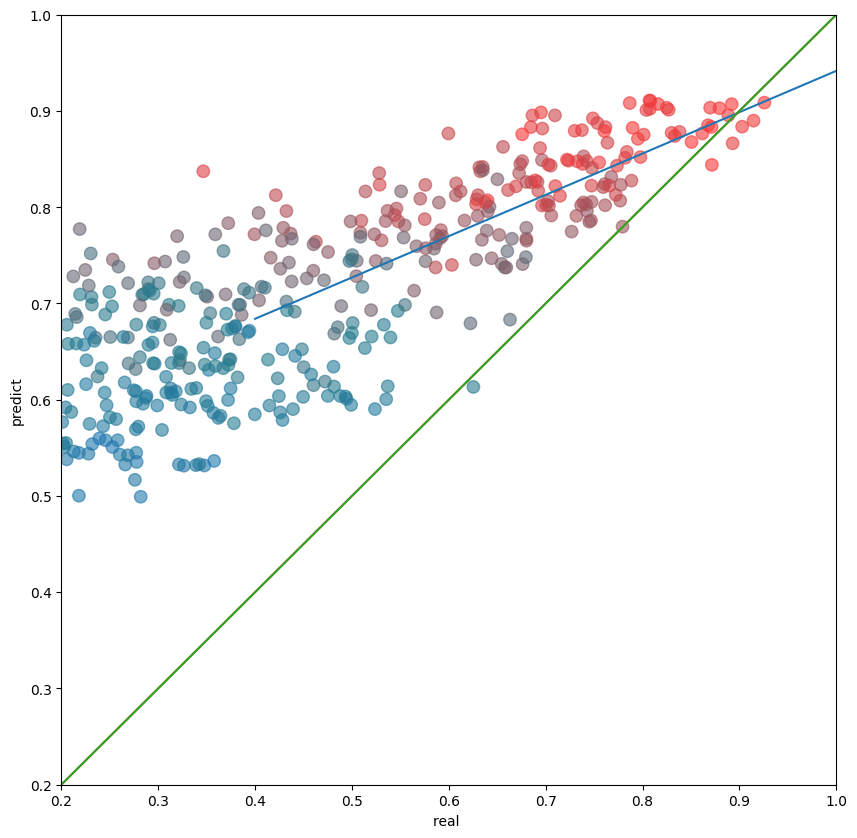

In [33]:
xebs = []
for cir in test_dataset:
    xebs.append(get_baseline_predict(cir, xeb_single_average_error, xeb_couple_average_error))
xebs = np.array(xebs)
plot_scaater(test_reals, xebs, durations, name = f'scatter_xeb.png')
print(np.abs(xebs-test_reals).mean(), np.abs(xebs-test_reals).std())
delta_xeb=np.abs(np.array(test_reals)-np.array(xebs)).tolist()


[0.02850174765396118, 0.05369056639273961, 0.04261930113747007, 0.04703425869074735, 0.05713922398885091] [0.0766355580658424, 0.12434587746626913, 0.14771211402967202, 0.18918268858584641, 0.1495490426112124] [0.08524623623266192, 0.1404827891474728, 0.16421375177859904, 0.20343284320149546, 0.17279296546619327]


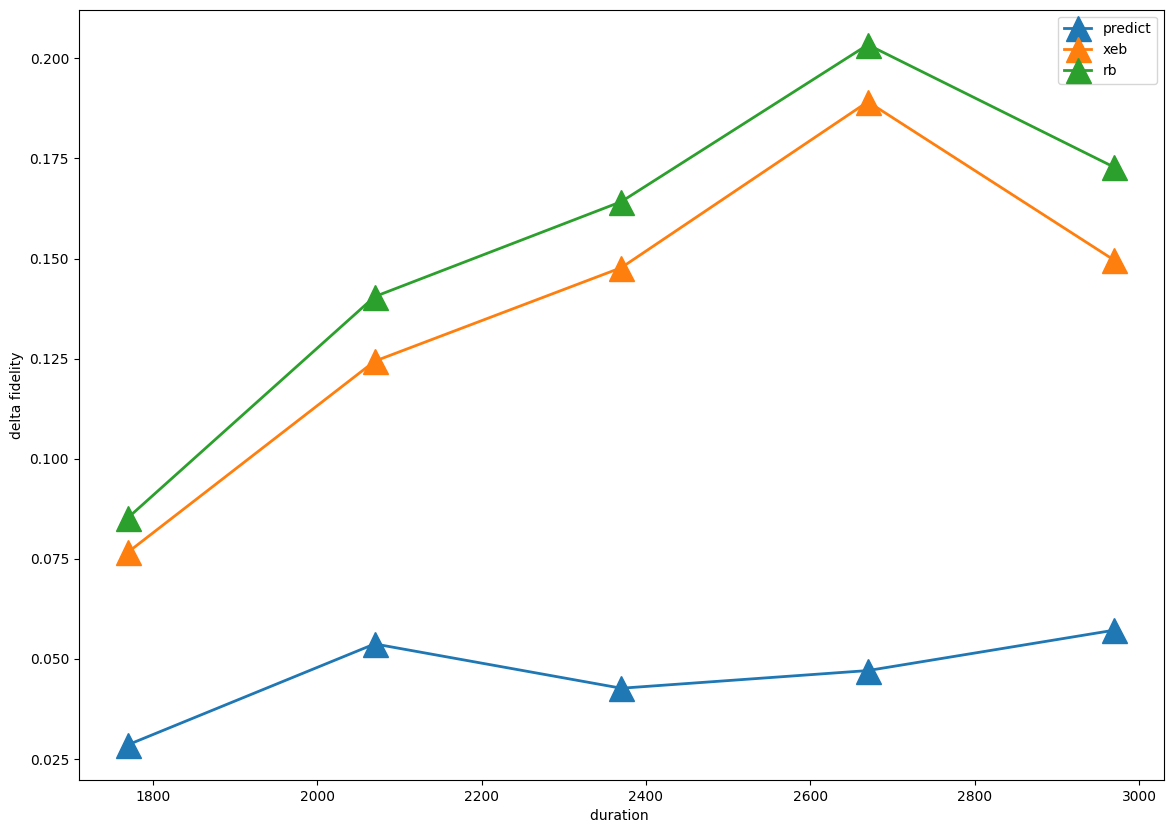

In [35]:
from plot.plot import get_duration2circuit_infos


fig, axes = plt.subplots(figsize=(14, 10))  # 创建一个图形对象和一个子图对象
duration_X, duration2circuit_index = get_duration2circuit_infos(durations,300,3000)

real_y,predict_y , xeb_y, rb_y= [],[],[], []
for circuit_index in duration2circuit_index:
    predict_y.append(np.abs(test_predicts[circuit_index] - test_reals[circuit_index]).mean())
    xeb_y.append(np.abs(xebs[circuit_index] - test_reals[circuit_index]).mean())
    rb_y.append(np.abs(rbs[circuit_index] - test_reals[circuit_index]).mean())
    


 
axes.plot(duration_X, predict_y ,markersize = 18,linewidth = 2, label='predict',marker = '^' )
axes.plot(duration_X, xeb_y ,markersize = 18,linewidth = 2, label='xeb',marker = '^' )
axes.plot(duration_X, rb_y ,markersize = 18,linewidth = 2, label='rb',marker = '^' )
print(predict_y, xeb_y, rb_y)

axes.set_xlabel('duration ')
axes.set_ylabel('delta fidelity')
axes.legend() # 添加图例
fig.show()
fig.savefig(f"delta_fidelity_duration.svg")  # step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


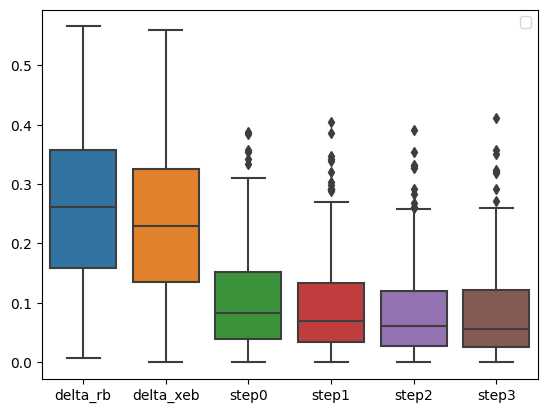

In [40]:
step0, step1, step2,step3 = delta_steps 
import seaborn as sns 
ax = sns.boxplot([delta_rb, delta_xeb, step0, step1,  step2, step3])
fig = ax.get_figure()
ax.legend()
ax.set_xticklabels(['rb', 'xeb', 'step0', 'step1',  'step2', 'step3'])
fig.savefig('boxplot.svg')